In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from keras import layers
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import pickle

## Parameters

In [2]:
first_datetime_to_test = datetime(2023, 11, 17, 13, 0, 0) # Date and time at which the data is split into train and test sets.
train_lenght = timedelta(days=300, hours=0, minutes=0)
test_lenght = timedelta(days=6, hours=0, minutes=0)

seq_length = 6 #RNN parameter ("model memory")

prediction_window = 6

# PATHS
input_resample_csv_path = './dataframes/dfResample.csv'
output_predictions_csv_path = './dataframes/dfPredictions.csv'
output_model_pickle_path = './RNN.pickle' 
output_scaler_pickle_path = './RNN_scaler.pickle' 

minutes_inc = 30 #Note: It must be equal to freq_time

## Data Split: Training and Testing

In [3]:
df = pd.read_csv(input_resample_csv_path)
df['time'] = pd.to_datetime(df['last_updated_dt'])

trainStart = first_datetime_to_test - train_lenght
testEnd = first_datetime_to_test + test_lenght

dfTrain = df[(trainStart  < df['time'])  & (df['time'] < first_datetime_to_test)]
dfTest = df[(first_datetime_to_test <= df['time']) & (df['time'] <= testEnd)]
df = pd.concat([dfTrain, dfTest], ignore_index=True)

In [4]:
def df_to_X_y(data):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [5]:
# Testing function df_to_X_y
training_data = df['time'].values.reshape(-1, 1)

x, y = df_to_X_y(training_data)

train_size = len(dfTrain) - seq_length

trainXtime = np.array(x[0:train_size])
trainYtime = np.array(y[0:train_size])

testXtime = np.array(x[train_size:])
testYTime = np.array(y[train_size:])

print('The last record used for training')
print(trainXtime[trainXtime.shape[0]-1])

print('The known y value of the last record used for training')
print(trainYtime[trainYtime.shape[0]-1])

print('First record we want to test')
print(testXtime[0])

print('First record we want to predict')
print(testYTime[0])

El ultimo registro que se utiliza para entrenar
[['2023-11-17T09:30:00.000000000']
 ['2023-11-17T10:00:00.000000000']
 ['2023-11-17T10:30:00.000000000']
 ['2023-11-17T11:00:00.000000000']
 ['2023-11-17T11:30:00.000000000']
 ['2023-11-17T12:00:00.000000000']]
El valor y que conocemos del ultimo registro para entrenar que se utiliza para entrenar
[['2023-11-17T12:30:00.000000000']]
Primer registro que queremos testear
[['2023-11-17T10:00:00.000000000']
 ['2023-11-17T10:30:00.000000000']
 ['2023-11-17T11:00:00.000000000']
 ['2023-11-17T11:30:00.000000000']
 ['2023-11-17T12:00:00.000000000']
 ['2023-11-17T12:30:00.000000000']]
Primer registro que queremos predecir
[['2023-11-17T13:00:00.000000000']]


In [6]:
sc = StandardScaler()
training_data = sc.fit_transform(df['num_bikes_available'].values.reshape(-1, 1))

x, y = df_to_X_y(training_data)

train_size = len(dfTrain) - seq_length

trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])

testX = np.array(x[train_size:])
testY = np.array(y[train_size:])

## Model Creation and Training

In [7]:
model = keras.Sequential()

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(32))

model.add(layers.Dropout(0.2))

# Add a Dense layer with 10 units.
model.add(layers.Dense(1))

model.build(input_shape=trainX.shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (14393, 32)               4352      
                                                                 
 dropout (Dropout)           (14393, 32)               0         
                                                                 
 dense (Dense)               (14393, 1)                33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=["mse"],
)

In [9]:
batch_size = 4
history = model.fit(
    trainX, trainY, batch_size=batch_size, epochs=10
)

Epoch 1/10


3599/3599 [==============================] - 21s 5ms/step - loss: 0.1402 - mse: 0.1402
Epoch 2/10
3599/3599 [==============================] - 15s 4ms/step - loss: 0.1035 - mse: 0.1035
Epoch 3/10
3599/3599 [==============================] - 14s 4ms/step - loss: 0.0991 - mse: 0.0991
Epoch 4/10
3599/3599 [==============================] - 14s 4ms/step - loss: 0.0985 - mse: 0.0985
Epoch 5/10
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0976 - mse: 0.0976
Epoch 6/10
3599/3599 [==============================] - 16s 4ms/step - loss: 0.0961 - mse: 0.0961
Epoch 7/10
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0954 - mse: 0.0954
Epoch 8/10
3599/3599 [==============================] - 16s 5ms/step - loss: 0.0953 - mse: 0.0953
Epoch 9/10
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0956 - mse: 0.0956
Epoch 10/10
3599/3599 [==============================] - 16s 4ms/step - loss: 0.0956 - mse: 0.0956


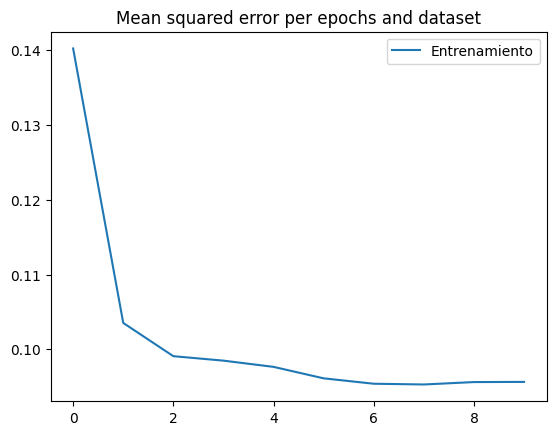

In [10]:
plt.plot(history.history['mse'], label='Traning')
plt.title('Mean squared error per epochs and dataset')
plt.legend()
plt.show()

## Cross Validation

In [12]:
dfPredictions = pd.DataFrame()
testX_i = testX
testY_i = testY
testYTime_i = testYTime

for i in range(1, prediction_window + 1):
    aux = model.predict(testX_i)

    dfAux = pd.DataFrame({
        'LastTimeWithData': 0,
        'ti': i,
        'Time': testYTime_i[:,0].flatten(),
        'Predict': sc.inverse_transform(aux).flatten(),
        'Real': sc.inverse_transform(testY_i[:,0]).flatten()
    })
    dfPredictions = pd.concat([dfPredictions, dfAux], ignore_index=True)

    testX_i = np.hstack((testX_i, aux[:, np.newaxis]))  #le agrego una dimension a aux para poder hacer hstack
    testX_i = testX_i[:, -seq_length:, :]   #quito la primera columna

    nan_array = [np.array([[np.nan]])]
    testY_i = testY_i[1:]
    testY_i = np.concatenate([testY_i, nan_array], axis=0)

    nat_array = [np.array([[np.datetime64('NaT')]])]
    testYTime_i = testYTime_i[1:]
    testYTime_i = np.concatenate([testYTime_i, nat_array], axis=0)


dfPredictions['LastTimeWithData'] = dfPredictions['Time'] - pd.to_timedelta(dfPredictions['ti'] * minutes_inc, unit='m')


10/10 [==============================] - 0s 4ms/step


## Saving Outputs

In [17]:
df.to_csv(output_predictions_csv_path, index=False)

In [18]:
# Guardar el modelo en un archivo pickle
with open(output_model_pickle_path, 'wb') as file:
    pickle.dump(model, file)

with open(output_scaler_pickle_path, 'wb') as file:
    pickle.dump(sc, file)
 

## Prediction Analysis

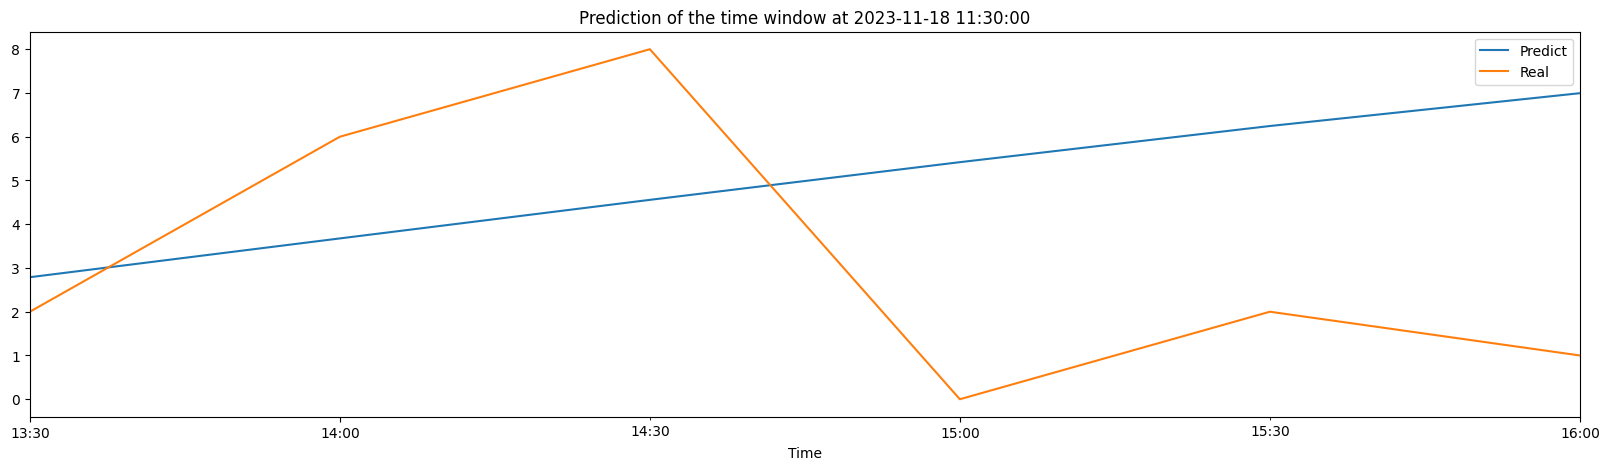

In [25]:
dt = datetime(2023, 11, 18, 11, 30, 0)
dfPlot = dfPredictions
dfPlot = dfPlot[dfPlot['LastTimeWithData']==dt]
dfPlot[['Time', 'Predict', 'Real']].plot(x='Time', title=f'Prediction of the time window at {dt}', figsize=(20, 5))
plt.show()

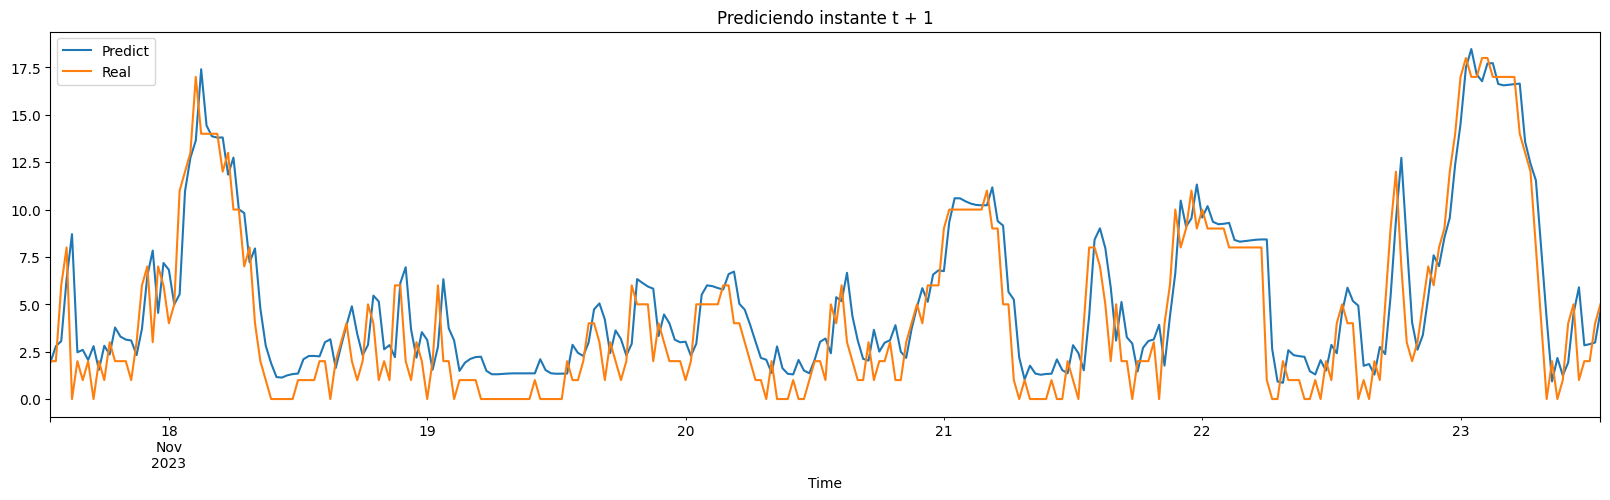

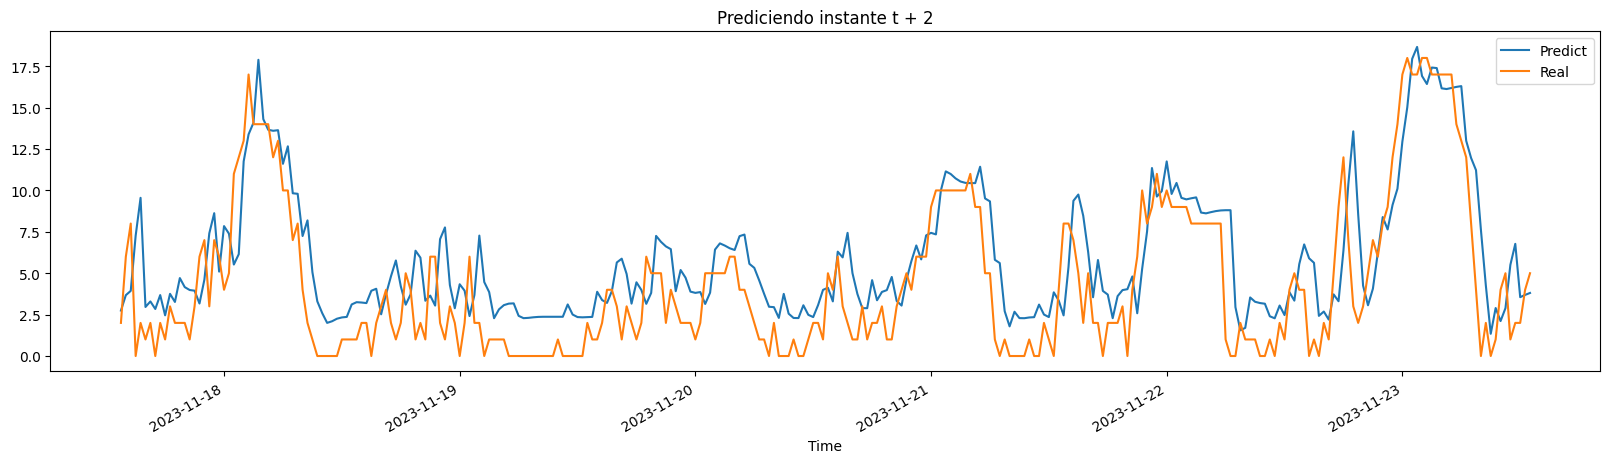

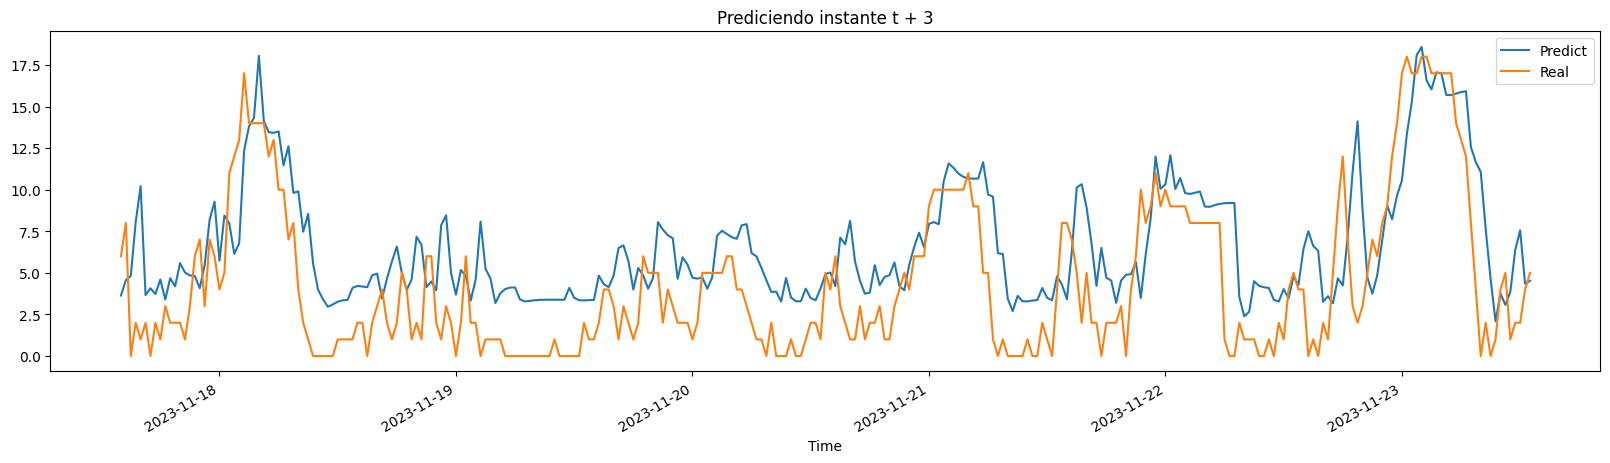

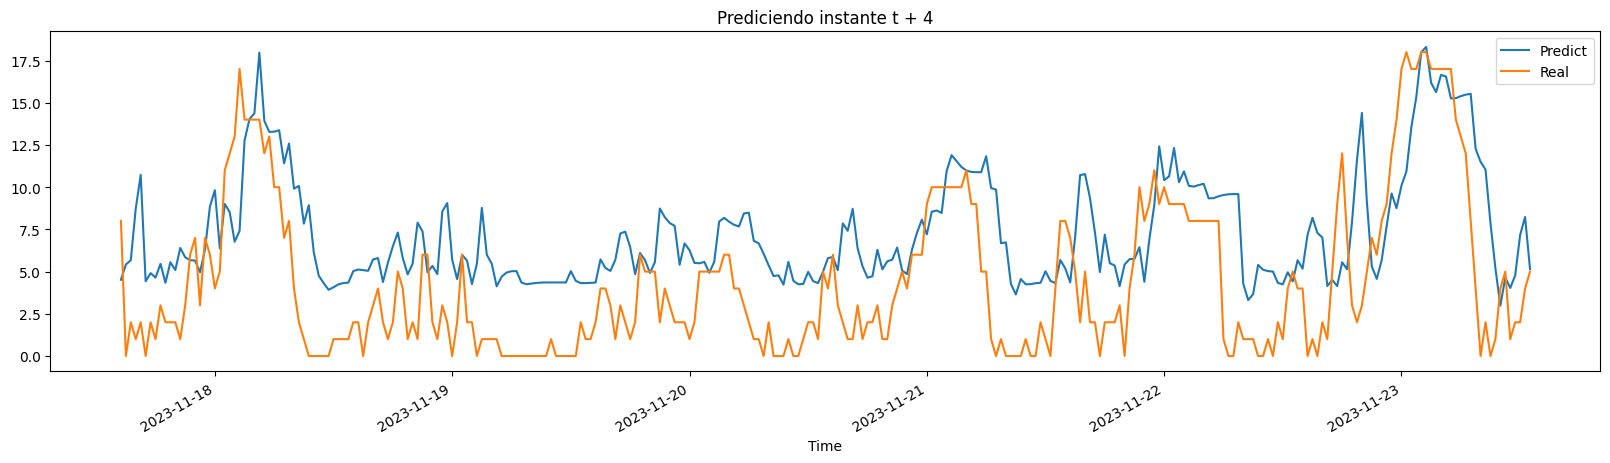

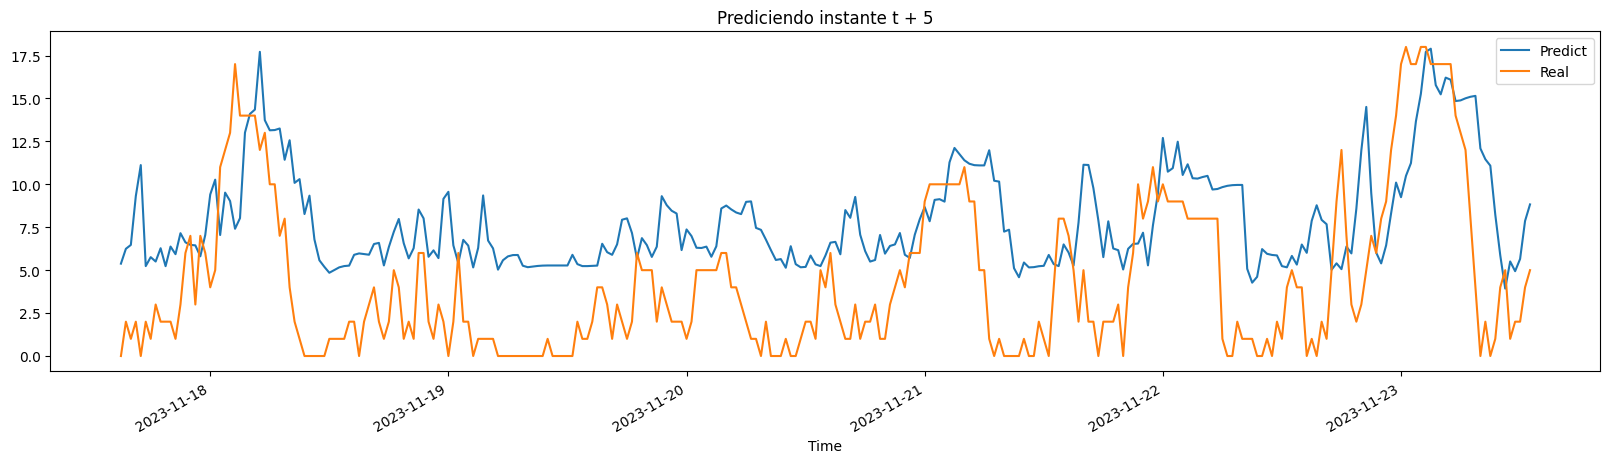

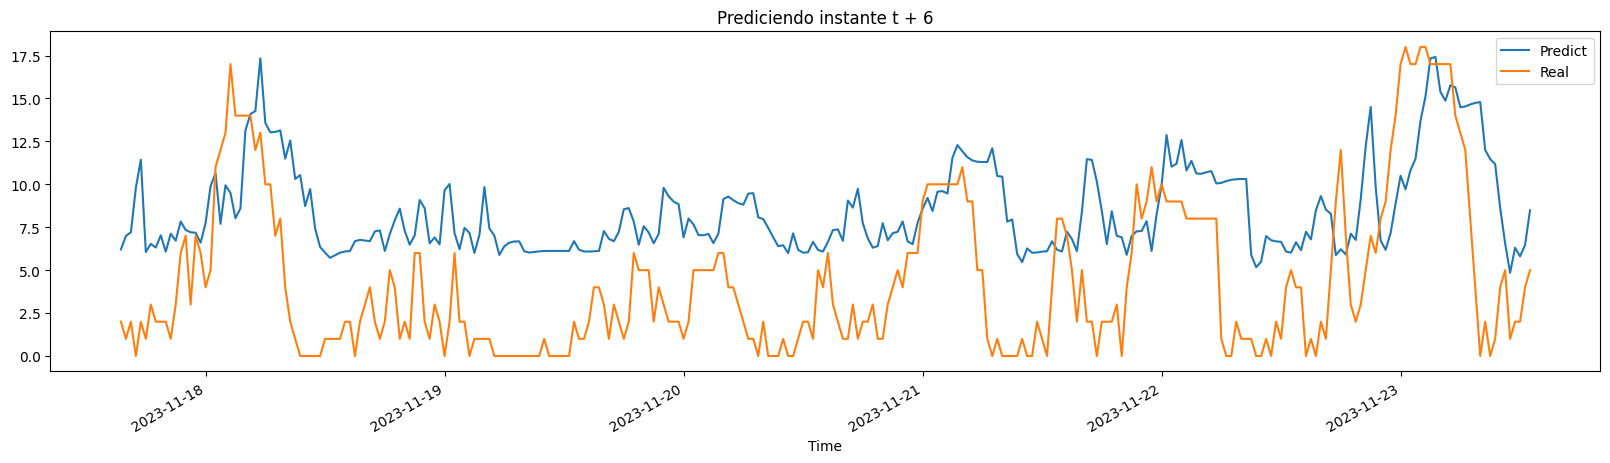

In [20]:
for ti in range(1, prediction_window + 1):
    dfPlot = dfPredictions
    dfPlot = dfPlot[dfPlot['ti'] == ti]
    dfPlot[['Time', 'Predict', 'Real']].plot(x='Time', title=f'Prediciendo instante t + {ti}', figsize=(20, 5))
    plt.show()
